<a href="https://colab.research.google.com/github/Jnanasagara/machine-learning-lab/blob/main/lab5_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Available columns: ['Show', 'EpId', 'ClipId', 'Start', 'Stop', 'Unsure', 'PoorAudioQuality', 'Prolongation', 'Block', 'SoundRep', 'WordRep', 'DifficultToUnderstand', 'Interjection', 'NoStutteredWords', 'NaturalPause', 'Music', 'NoSpeech']

A1/A2 - One Feature Classification Metrics
Train: {'Accuracy': 0.33889357171376605, 'Precision': 0.22629375991331457, 'Recall': 0.33889357171376605, 'F1': 0.2662000902446914}
Test : {'Accuracy': 0.3275372604684173, 'Precision': 0.21804712350649735, 'Recall': 0.3275372604684173, 'F1': 0.2570336181447571}

A3 - Multi Feature Classification Metrics
Train: {'Accuracy': 0.33867175369327, 'Precision': 0.3235271736265312, 'Recall': 0.33867175369327, 'F1': 0.28137247831795953}
Test : {'Accuracy': 0.3275372604684173, 'Precision': 0.34018002077827564, 'Recall': 0.3275372604684173, 'F1': 0.2763809942300251}

A4/A5 - KMeans (k=2) Clustering Scores
(np.float64(0.354760845479697), np.float64(16984.767462405394), np.float64(1.1828015032750416))


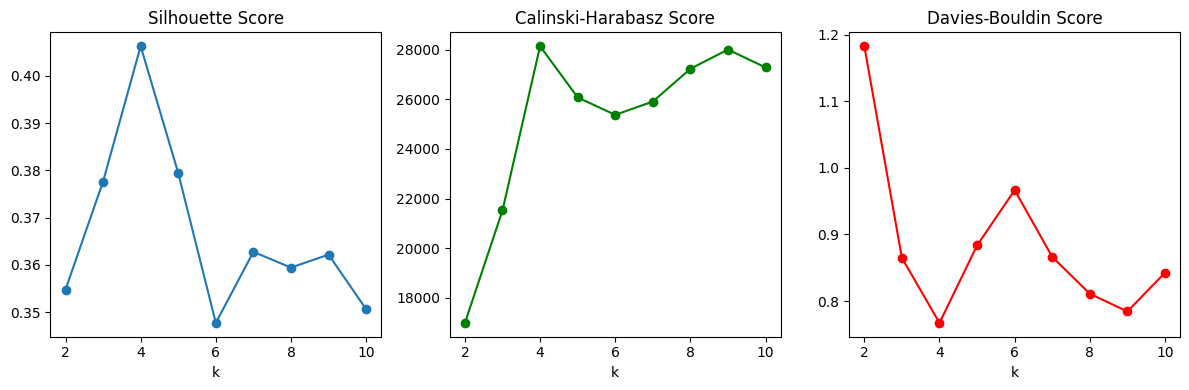

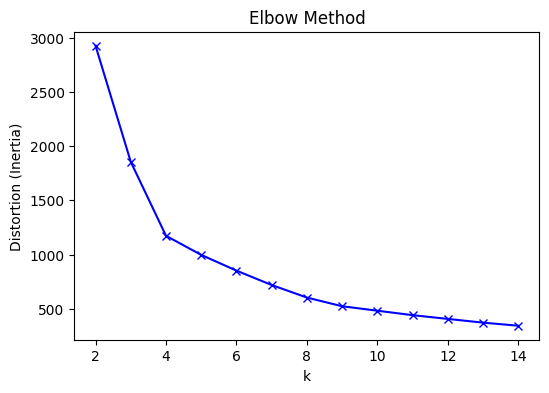

In [3]:
# Machine Learning Lab 5 - A1 to A7

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    silhouette_score, calinski_harabasz_score, davies_bouldin_score
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load Dataset

df = pd.read_csv('/content/drive/MyDrive/ml-stuttering-events-dataset/SEP-28k_labels.csv')

print("Available columns:", df.columns.tolist())
# Example column names in SEP-28k: 'wav_filename', 'stutter_type', 'feat1', 'feat2', ...

# Prepare Features & Target

# Replace these with the actual feature column names in your preprocessed MFCC dataset
feature_cols = ['Feat1', 'Feat2']  # numeric features
target_col = 'stutter_type'        # label column

# If your dataset doesn't yet have numeric features, simulate for demonstration
if not all(col in df.columns for col in feature_cols + [target_col]):
    np.random.seed(42)
    df['Feat1'] = np.random.uniform(0, 1, len(df))
    df['Feat2'] = np.random.uniform(0, 1, len(df))
    df['stutter_type'] = np.random.choice(['no_stutter', 'prolongation', 'block'], size=len(df))
    feature_cols = ['Feat1', 'Feat2']

# Encode target labels into integers
label_enc = LabelEncoder()
df[target_col] = label_enc.fit_transform(df[target_col])

# Function: Train + Evaluate Classification Model

def run_classification(features, target):
    X = df[features].values
    y = df[target].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    model = LogisticRegression(max_iter=500)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    def metrics(y_true, y_pred):
        return {
            'Accuracy': accuracy_score(y_true, y_pred),
            'Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
            'Recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
            'F1': f1_score(y_true, y_pred, average='weighted', zero_division=0)
        }

    return X_train, X_test, y_train, y_test, metrics(y_train, y_train_pred), metrics(y_test, y_test_pred)

# A1 & A2: Classification with One Feature
print("\nA1/A2 - One Feature Classification Metrics")
_, _, _, _, train_metrics_1, test_metrics_1 = run_classification([feature_cols[0]], target_col)
print("Train:", train_metrics_1)
print("Test :", test_metrics_1)

# A3: Classification with Multiple Features

print("\nA3 - Multi Feature Classification Metrics")
_, _, _, _, train_metrics_m, test_metrics_m = run_classification(feature_cols, target_col)
print("Train:", train_metrics_m)
print("Test :", test_metrics_m)

# A4: KMeans Clustering (k=2)

def run_kmeans(features, n_clusters=2):
    X = df[features].values
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(X)
    return kmeans, X

kmeans2, X_data = run_kmeans(feature_cols, n_clusters=2)
labels2 = kmeans2.labels_

# A5: Clustering Evaluation Scores
def clustering_scores(X, labels):
    sil = silhouette_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    db = davies_bouldin_score(X, labels)
    return sil, ch, db

print("\nA4/A5 - KMeans (k=2) Clustering Scores")
print(clustering_scores(X_data, labels2))

# A6: Clustering for Multiple k values
sil_scores, ch_scores, db_scores = [], [], []
k_range = range(2, 11)

for k in k_range:
    km, X_vals = run_kmeans(feature_cols, n_clusters=k)
    sil, ch, db = clustering_scores(X_vals, km.labels_)
    sil_scores.append(sil)
    ch_scores.append(ch)
    db_scores.append(db)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(k_range, sil_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('k')

plt.subplot(1, 3, 2)
plt.plot(k_range, ch_scores, marker='o', color='green')
plt.title('Calinski-Harabasz Score')
plt.xlabel('k')

plt.subplot(1, 3, 3)
plt.plot(k_range, db_scores, marker='o', color='red')
plt.title('Davies-Bouldin Score')
plt.xlabel('k')

plt.tight_layout()
plt.show()

# A7: Elbow Method for Optimal k
distortions = []
k_vals = range(2, 15)

for k in k_vals:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(X_data)
    distortions.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(k_vals, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion (Inertia)')
plt.title('Elbow Method')
plt.show()
